## Self Attentive Sequential Recommendation / SASRec

**Note: This code is copied from https://github.com/pmixer/SASRec.pytorch/tree/main which is a modernized approach (using more up to date Python modules) to the code in the orginal SASRec paper (Self-Attentive Sequential Recommendation). It is not our original code! Please see citation below for the original SASRec paper.**

@article{huang2025revisiting_sasrec,
  title={Revisiting Self-Attentive Sequential Recommendation},
  author={Huang, Zan},
  journal={CoRR},
  volume={abs/2504.09596},
  url={https://arxiv.org/abs/2504.09596},
  eprinttype={arXiv},
  eprint={2504.09596},
  year={2025}
}

In [1]:
import pandas as pd

book_test_df = pd.read_csv('../data/Books.test.csv.gz', compression='gzip', sep=',', header=0)
book_val_df = pd.read_csv('../data/Books.valid.csv.gz', compression='gzip', sep=',', header=0)
book_train_df = pd.read_csv('../data/Books.train.csv.gz', compression='gzip', sep=',', header=0)

book_train_df.head()

,user_id,parent_asin,rating,timestamp,history
0,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1446304000,5.0,1441260345000,NaN
1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1564770672,5.0,1441260365000,1446304000
2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1442450703,5.0,1523093714024,1446304000 1564770672
3,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1780671067,1.0,1611623223325,1446304000 1564770672 1442450703
4,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1645671127,3.0,1612044209266,1446304000 1564770672 1442450703 1780671067


### Leave-Last-Out Splitting
A data-splitting strategy to pick up the lastest two item interactions for evaluation.

Specially, given a chronological user interaction sequence of length N:

Training part: the first N-2 items;

Validation part: the (N-1)-th item;

Testing part: the N-th item. In this case N >= 5. 


Using the presupplied Train, Validation and Test sets encourages consistent benchmarks. 

In [2]:
print("Training set: ", book_train_df.shape)
print("Val Set: ", book_val_df.shape)
print("Test Set: ", book_test_df.shape)
print(book_test_df.head())
print()
print(book_val_df.head())
print("Unique Users in Train set: ", book_train_df['user_id'].nunique())
print("Unique Users in Test set: ", book_test_df['user_id'].nunique())
print("Unique Users in eval set: ", book_val_df['user_id'].nunique())
print(book_val_df.tail())
print(book_test_df.tail())

print("Num Unique Items: ", book_train_df['parent_asin'].nunique())
print("Num Unique Users: ", book_train_df['user_id'].nunique())


Training set:  (7935557, 5)
Val Set:  (776370, 5)
Test Set:  (776370, 5)
                        user_id parent_asin  rating      timestamp  \
0  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  0593235657     5.0  1640629604904   
1  AGKASBHYZPGTEPO6LWZPVJWB2BVA  0803736800     4.0  1454676557000   
2  AGXFEGMNVCSTSYYA5UWXDV7AFSXA  1542046599     5.0  1605649719611   
3  AFWHJ6O3PV4JC7PVOJH6CPULO2KQ  0679450815     5.0  1638987703546   
4  AHXBL3QDWZGJYH7A5CMPFNUPMF7Q  1250866448     5.0  1669414969335   

                                             history  
0  1446304000 1564770672 1442450703 1780671067 16...  
1  0811849783 0803729952 0735336296 1508558884 08...  
2        1578052009 1477493395 1594747350 1594749310  
3  B00INIQVJA 1496407903 1974633225 B07KD27RHM 16...  
4  0920668372 1589255208 2764322836 2764330898 00...  

                        user_id parent_asin  rating      timestamp  \
0  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  1782490671     5.0  1640383495102   
1  AGKASBHYZPGTEPO6LWZPVJWB2BVA  08

Merge train, validation and test sets, map each value to an integer, group and sort each user's interactions by timestamp (to preserve leave-last-out splitting when eventually split up again), and output to txt file

In [3]:
# Combine all interactions
merged_df = pd.concat([book_train_df, book_val_df, book_test_df], ignore_index=True)

merged_df.rename(columns={'user_id': 'userID', 'parent_asin': 'itemID'}, inplace=True) #filter_k_core function needs these column names
merged_df.rename(columns={'userID': 'user_id', 'itemID': 'parent_asin'}, inplace=True) #change column names back

# Make sure user/item IDs are integers starting from 1
user_set = set(merged_df['user_id'].unique())
item_set = set(merged_df['parent_asin'].unique())

user_map = dict()
item_map = dict()

for u, user in enumerate(user_set):
    user_map[user] = u+1

for i, item in enumerate(item_set):
    item_map[item] = i+1

merged_df['user_id'] = merged_df['user_id'].map(user_map)
merged_df['parent_asin'] = merged_df['parent_asin'].map(item_map)
print(merged_df.head())

# Sort by user and timestamp
merged_df = merged_df.sort_values(['user_id', 'timestamp'])

# Keep only the columns SASRecDataset expects
merged_df = merged_df[['user_id', 'parent_asin']]

# Save to a single TSV
merged_df.to_csv("../data/book_all.txt", sep=" ", header=False, index=False)

   user_id  parent_asin  rating      timestamp  \
0   190789       100294     5.0  1441260345000   
1   190789       392977     5.0  1441260365000   
2   190789        44362     5.0  1523093714024   
3   190789       338738     1.0  1611623223325   
4   190789       337380     3.0  1612044209266   

                                       history  
0                                          NaN  
1                                   1446304000  
2                        1446304000 1564770672  
3             1446304000 1564770672 1442450703  
4  1446304000 1564770672 1442450703 1780671067  


Note: Start from here if already computed the book_all.txt file

In [3]:
# Imports
import os
import time
import torch
import numpy as np

# Your SASRec model and utility functions
from model import SASRec
from utils import build_index, data_partition, WarpSampler, evaluate, evaluate_valid

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [4]:
print("Torch version:", torch.__version__)
print("Built with CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())

Torch version: 2.9.1+cu128
Built with CUDA: 12.8
CUDA available: True


In [5]:
# Dataset / directories
dataset = 'data/book_all.txt'  # path to preprocessed dataset
train_dir = 'results'   # folder to save logs / models

#TODO run with more epochs, longer maxlen, and see if ndcg and hit rate improve
# Training hyperparameters
batch_size = 128
lr = 0.001
maxlen = 10
hidden_units = 50
num_blocks = 2
num_epochs = 20  # smaller for quick benchmark
num_heads = 1 #number of heads in original SASRec paper
dropout_rate = 0.2
l2_emb = 0.0
inference_only = False
state_dict_path = None
norm_first = False

# Create output folder if it doesn't exist
folder = f"{dataset}_{train_dir}"
os.makedirs(folder, exist_ok=True)


In [6]:
# Build user-item indexes
u2i_index, i2u_index = build_index(dataset)

# Load partitioned dataset
dataset_part = data_partition(dataset)
user_train, user_valid, user_test, usernum, itemnum = dataset_part

# Average sequence length
avg_seq_len = np.mean([len(seq) for seq in user_train.values()])
print(f"Average sequence length: {avg_seq_len:.2f}")

# Initialize sampler
sampler = WarpSampler(user_train, usernum, itemnum, batch_size=batch_size, maxlen=maxlen, n_workers=3)


Average sequence length: 10.22


In [7]:
# Initialize SASRec args
args = type('obj', (object,), {})()  # dummy object to mimic args
args.device = device
args.hidden_units = hidden_units
args.num_blocks = num_blocks
args.num_heads = num_heads
args.dropout_rate = dropout_rate
args.maxlen = maxlen
args.l2_emb = l2_emb
args.norm_first = False

In [8]:
model = SASRec(usernum, itemnum, args).to(device)

# Xavier initialization
for name, param in model.named_parameters():
    try:
        torch.nn.init.xavier_normal_(param.data)
    except:
        pass

# Zero padding embeddings
model.pos_emb.weight.data[0, :] = 0
model.item_emb.weight.data[0, :] = 0

# Loss and optimizer
bce_criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98))

# Training mode
model.train()


SASRec(
  (item_emb): Embedding(495064, 50, padding_idx=0)
  (pos_emb): Embedding(11, 50, padding_idx=0)
  (emb_dropout): Dropout(p=0.2, inplace=False)
  (attention_layernorms): ModuleList(
    (0-1): 2 x LayerNorm((50,), eps=1e-08, elementwise_affine=True)
  )
  (attention_layers): ModuleList(
    (0-1): 2 x MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
    )
  )
  (forward_layernorms): ModuleList(
    (0-1): 2 x LayerNorm((50,), eps=1e-08, elementwise_affine=True)
  )
  (forward_layers): ModuleList(
    (0-1): 2 x PointWiseFeedForward(
      (conv1): Conv1d(50, 50, kernel_size=(1,), stride=(1,))
      (dropout1): Dropout(p=0.2, inplace=False)
      (relu): ReLU()
      (conv2): Conv1d(50, 50, kernel_size=(1,), stride=(1,))
      (dropout2): Dropout(p=0.2, inplace=False)
    )
  )
  (last_layernorm): LayerNorm((50,), eps=1e-08, elementwise_affine=True)
)

In [9]:
best_val_ndcg, best_val_hr = 0.0, 0.0
best_test_ndcg, best_test_hr = 0.0, 0.0
T = 0.0
t0 = time.time()
num_batch = (len(user_train) - 1) // batch_size + 1

for epoch in range(1, num_epochs + 1):
    if inference_only:
        break
    for step in range(num_batch):
        u, seq, pos, neg = sampler.next_batch()
        u, seq, pos, neg = np.array(u), np.array(seq), np.array(pos), np.array(neg)

        pos_logits, neg_logits = model(u, seq, pos, neg)

        pos_labels = torch.ones_like(pos_logits, device=device)
        neg_labels = torch.zeros_like(neg_logits, device=device)

        optimizer.zero_grad()
        indices = np.where(pos != 0)
        loss = bce_criterion(pos_logits[indices], pos_labels[indices])
        loss += bce_criterion(neg_logits[indices], neg_labels[indices])
        for param in model.item_emb.parameters():
            loss += l2_emb * torch.sum(param ** 2)

        loss.backward()
        optimizer.step()

        if step % 1000 == 0:
            print(f"Epoch {epoch}, Step {step}, Loss: {loss.item():.4f}")

    # Evaluate every 20 epochs
    if epoch % 20 == 0:
        model.eval()
        t_valid = evaluate_valid(model, dataset_part, args)
        t_test = evaluate(model, dataset_part, args)
        #print(f"Epoch {epoch}: Valid NDCG@10 {t_valid[0]:.4f}, HR@10 {t_valid[1]:.4f}; Test NDCG@10 {t_test[0]:.4f}, HR@10 {t_test[1]:.4f}")
        model.train()


Epoch 1, Step 0, Loss: 1.3864
Epoch 1, Step 1000, Loss: 1.1463
Epoch 1, Step 2000, Loss: 1.1282
Epoch 1, Step 3000, Loss: 1.1197
Epoch 1, Step 4000, Loss: 1.0987
Epoch 1, Step 5000, Loss: 1.1601
Epoch 1, Step 6000, Loss: 0.9676
Epoch 2, Step 0, Loss: 0.9883
Epoch 2, Step 1000, Loss: 0.9734
Epoch 2, Step 2000, Loss: 0.9927
Epoch 2, Step 3000, Loss: 1.0072
Epoch 2, Step 4000, Loss: 0.9587
Epoch 2, Step 5000, Loss: 0.9496
Epoch 2, Step 6000, Loss: 0.8885
Epoch 3, Step 0, Loss: 0.9302
Epoch 3, Step 1000, Loss: 0.9693
Epoch 3, Step 2000, Loss: 0.8984
Epoch 3, Step 3000, Loss: 0.9844
Epoch 3, Step 4000, Loss: 0.8751
Epoch 3, Step 5000, Loss: 0.8919
Epoch 3, Step 6000, Loss: 0.8538
Epoch 4, Step 0, Loss: 0.8559
Epoch 4, Step 1000, Loss: 0.8132
Epoch 4, Step 2000, Loss: 0.7352
Epoch 4, Step 3000, Loss: 0.7984
Epoch 4, Step 4000, Loss: 0.7695
Epoch 4, Step 5000, Loss: 0.7781
Epoch 4, Step 6000, Loss: 0.7390
Epoch 5, Step 0, Loss: 0.8244
Epoch 5, Step 1000, Loss: 0.7176
Epoch 5, Step 2000, Loss:

In [11]:
from utils import build_index, data_partition, WarpSampler, evaluate, evaluate_valid
model.eval() ##IMPORTANT necessary to set model into evaluation mode
t_valid = evaluate_valid(model, dataset_part, args)
t_test = evaluate(model, dataset_part, args)
print(f"Valid NDCG@10 {t_valid[0]:.4f}, HR@10 {t_valid[1]:.4f}; Test NDCG@10 {t_test[0]:.4f}, HR@10 {t_test[1]:.4f}")

........................................................................................................................................................................................................Valid NDCG@10 0.5160, HR@10 0.6866; Test NDCG@10 0.4866, HR@10 0.6529


Metrics above suffer from sampling evaluation inflation where NDCG@k and Hit Rate@k are artificially high. This happens when you do not sample very many additional items during negative sampling, and you end up with inflated metrics. This was also the case in the original SASRec paper (see picture from original paper). 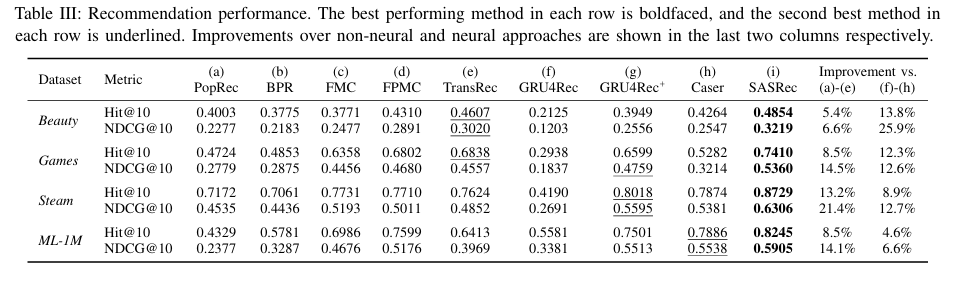

In [12]:
torch.save(model.state_dict(), "sasrec_weights_books2023.pth")


In [6]:
from model import SASRec

# Load metadata somewhere else, or hardcode temporarily
model = SASRec(usernum, itemnum, args)
model.load_state_dict(torch.load("sasrec_weights_books2023.pth"))
model.eval()


SASRec(
  (item_emb): Embedding(495064, 50, padding_idx=0)
  (pos_emb): Embedding(11, 50, padding_idx=0)
  (emb_dropout): Dropout(p=0.2, inplace=False)
  (attention_layernorms): ModuleList(
    (0-1): 2 x LayerNorm((50,), eps=1e-08, elementwise_affine=True)
  )
  (attention_layers): ModuleList(
    (0-1): 2 x MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
    )
  )
  (forward_layernorms): ModuleList(
    (0-1): 2 x LayerNorm((50,), eps=1e-08, elementwise_affine=True)
  )
  (forward_layers): ModuleList(
    (0-1): 2 x PointWiseFeedForward(
      (conv1): Conv1d(50, 50, kernel_size=(1,), stride=(1,))
      (dropout1): Dropout(p=0.2, inplace=False)
      (relu): ReLU()
      (conv2): Conv1d(50, 50, kernel_size=(1,), stride=(1,))
      (dropout2): Dropout(p=0.2, inplace=False)
    )
  )
  (last_layernorm): LayerNorm((50,), eps=1e-08, elementwise_affine=True)
)

Getting negative items from list of all items rather than only sampling 100 items like above. This will result in more realistic, and worse performance metrics. 

In [ ]:
import math
import numpy as np
import torch

def evaluate_full_ranking_split_multiK(
    model, dataset, args,
    split='valid',
    Ks=[5,10],
    chunk_size=50000,
    max_users=10000
):

    [train, valid, test, usernum, itemnum] = dataset
    split_data = valid if split=='valid' else test

    model.eval()

    hr = {k:0.0 for k in Ks}
    ndcg = {k:0.0 for k in Ks}
    mrr_total = 0.0
    auc_total = 0.0      # <-- NEW
    n_users = 0

    users = list(range(1, usernum+1))
    if max_users is not None and usernum > max_users:
        users = np.random.choice(users, max_users, replace=False)

    all_items = np.arange(1, itemnum+1)

    with torch.no_grad():
        for u in users:

            if len(train[u]) < 1 or len(split_data[u]) < 1:
                continue

            # Build sequence
            seq = np.zeros(args.maxlen, dtype=np.int64)
            idx = args.maxlen - 1
            for i in reversed(train[u]):
                seq[idx] = i
                idx -= 1
                if idx == -1: break

            pos_item = split_data[u][0]

            rated = set(train[u])
            rated.add(0)
            mask = np.array([i not in rated for i in all_items])
            candidates = all_items[mask]

            if pos_item not in candidates:
                continue

            pos_idx = np.where(candidates == pos_item)[0][0]

            #Ranking
            pos_score = None
            rank = 0

            for start in range(0, len(candidates), chunk_size):
                chunk_items = candidates[start:start + chunk_size]

                chunk_logits = model.predict(
                    np.array([u]),
                    np.array([seq]),
                    chunk_items
                )[0]

                if pos_score is None:
                    if start <= pos_idx < start + len(chunk_items):
                        pos_score = chunk_logits[pos_idx - start]

                if pos_score is not None:
                    rank += torch.sum(chunk_logits > pos_score).item()

            user_rank = rank + 1

            #MRR
            mrr_total += 1.0 / user_rank

            #HR & nDCG
            for K in Ks:
                if user_rank <= K:
                    hr[K] += 1.0
                    ndcg[K] += 1.0 / math.log2(user_rank + 1)

            #AUC
            num_neg = len(candidates) - 1
            auc_total += 1.0 - (rank / num_neg)

            n_users += 1

    # finalize metrics
    results = {
        "MRR": mrr_total / n_users,
        "AUC": auc_total / n_users 
    }
    for K in Ks:
        results[f"HR@{K}"] = hr[K] / n_users
        results[f"nDCG@{K}"] = ndcg[K] / n_users

    return results



In [21]:
val_metrics = evaluate_full_ranking_split_multiK(model, dataset_part, args, split='valid', Ks=[5, 10])
print("Val Metrics: ", val_metrics)

test_metrics = evaluate_full_ranking_split_multiK(model, dataset_part, args, split='test', Ks=[5, 10])
print("Test Metrics: ", test_metrics)

Val Metrics:  {'MRR': 0.01527997418889041, 'AUC': 0.9226296992077366, 'HR@5': 0.0199, 'nDCG@5': 0.012644915601452108, 'HR@10': 0.0308, 'nDCG@10': 0.01615392357324578}
Test Metrics:  {'MRR': 0.010331019373944086, 'AUC': 0.9094558160034716, 'HR@5': 0.0118, 'nDCG@5': 0.00760895320013234, 'HR@10': 0.0197, 'nDCG@10': 0.010163978208240018}
